In [1]:
import os
import cv2
import h5py
import glob
import torch
import numpy as np
import scipy.io as io
from PIL import Image
import matplotlib.pyplot as plt
import utils, metrics, models, io_img, core, plot, dynamics, preprocess, Gseg, slidingwindows_gradient
from io_img import logger_setup
from natsort import natsorted

# 1. Load Datasets

## 1.1 Load Image, Cell Instance Mask and Gene expressions

In [2]:
#Load original image
root_dir = "./datasets/original_data"
image = cv2.imread("{}/image/DAPI_3-4_right.jpg".format(root_dir))
image = image[..., [2,1,0]] #convert BGR into RGB

#Load initial cell instance mask
label = h5py.File("{}/label/label_3-4_right.mat".format(root_dir), 'r')
label = np.array(label['CellMap']).transpose()

#Load gene expressions
with open("{}/spots/DAPI_spots_3-4_right.csv".format(root_dir), 'r') as f:
            lines = f.readlines()
            lines = lines[1:]

spot_list = []
for line in lines:
    splits = line.split(',')
    spot_list.append([splits[0], splits[1], splits[2]])
        
spot = np.array(spot_list)

## 1.2 Visualize Image, Cell Instance Mask and Gene expressions

(-0.5, 7521.5, 3033.5, -0.5)

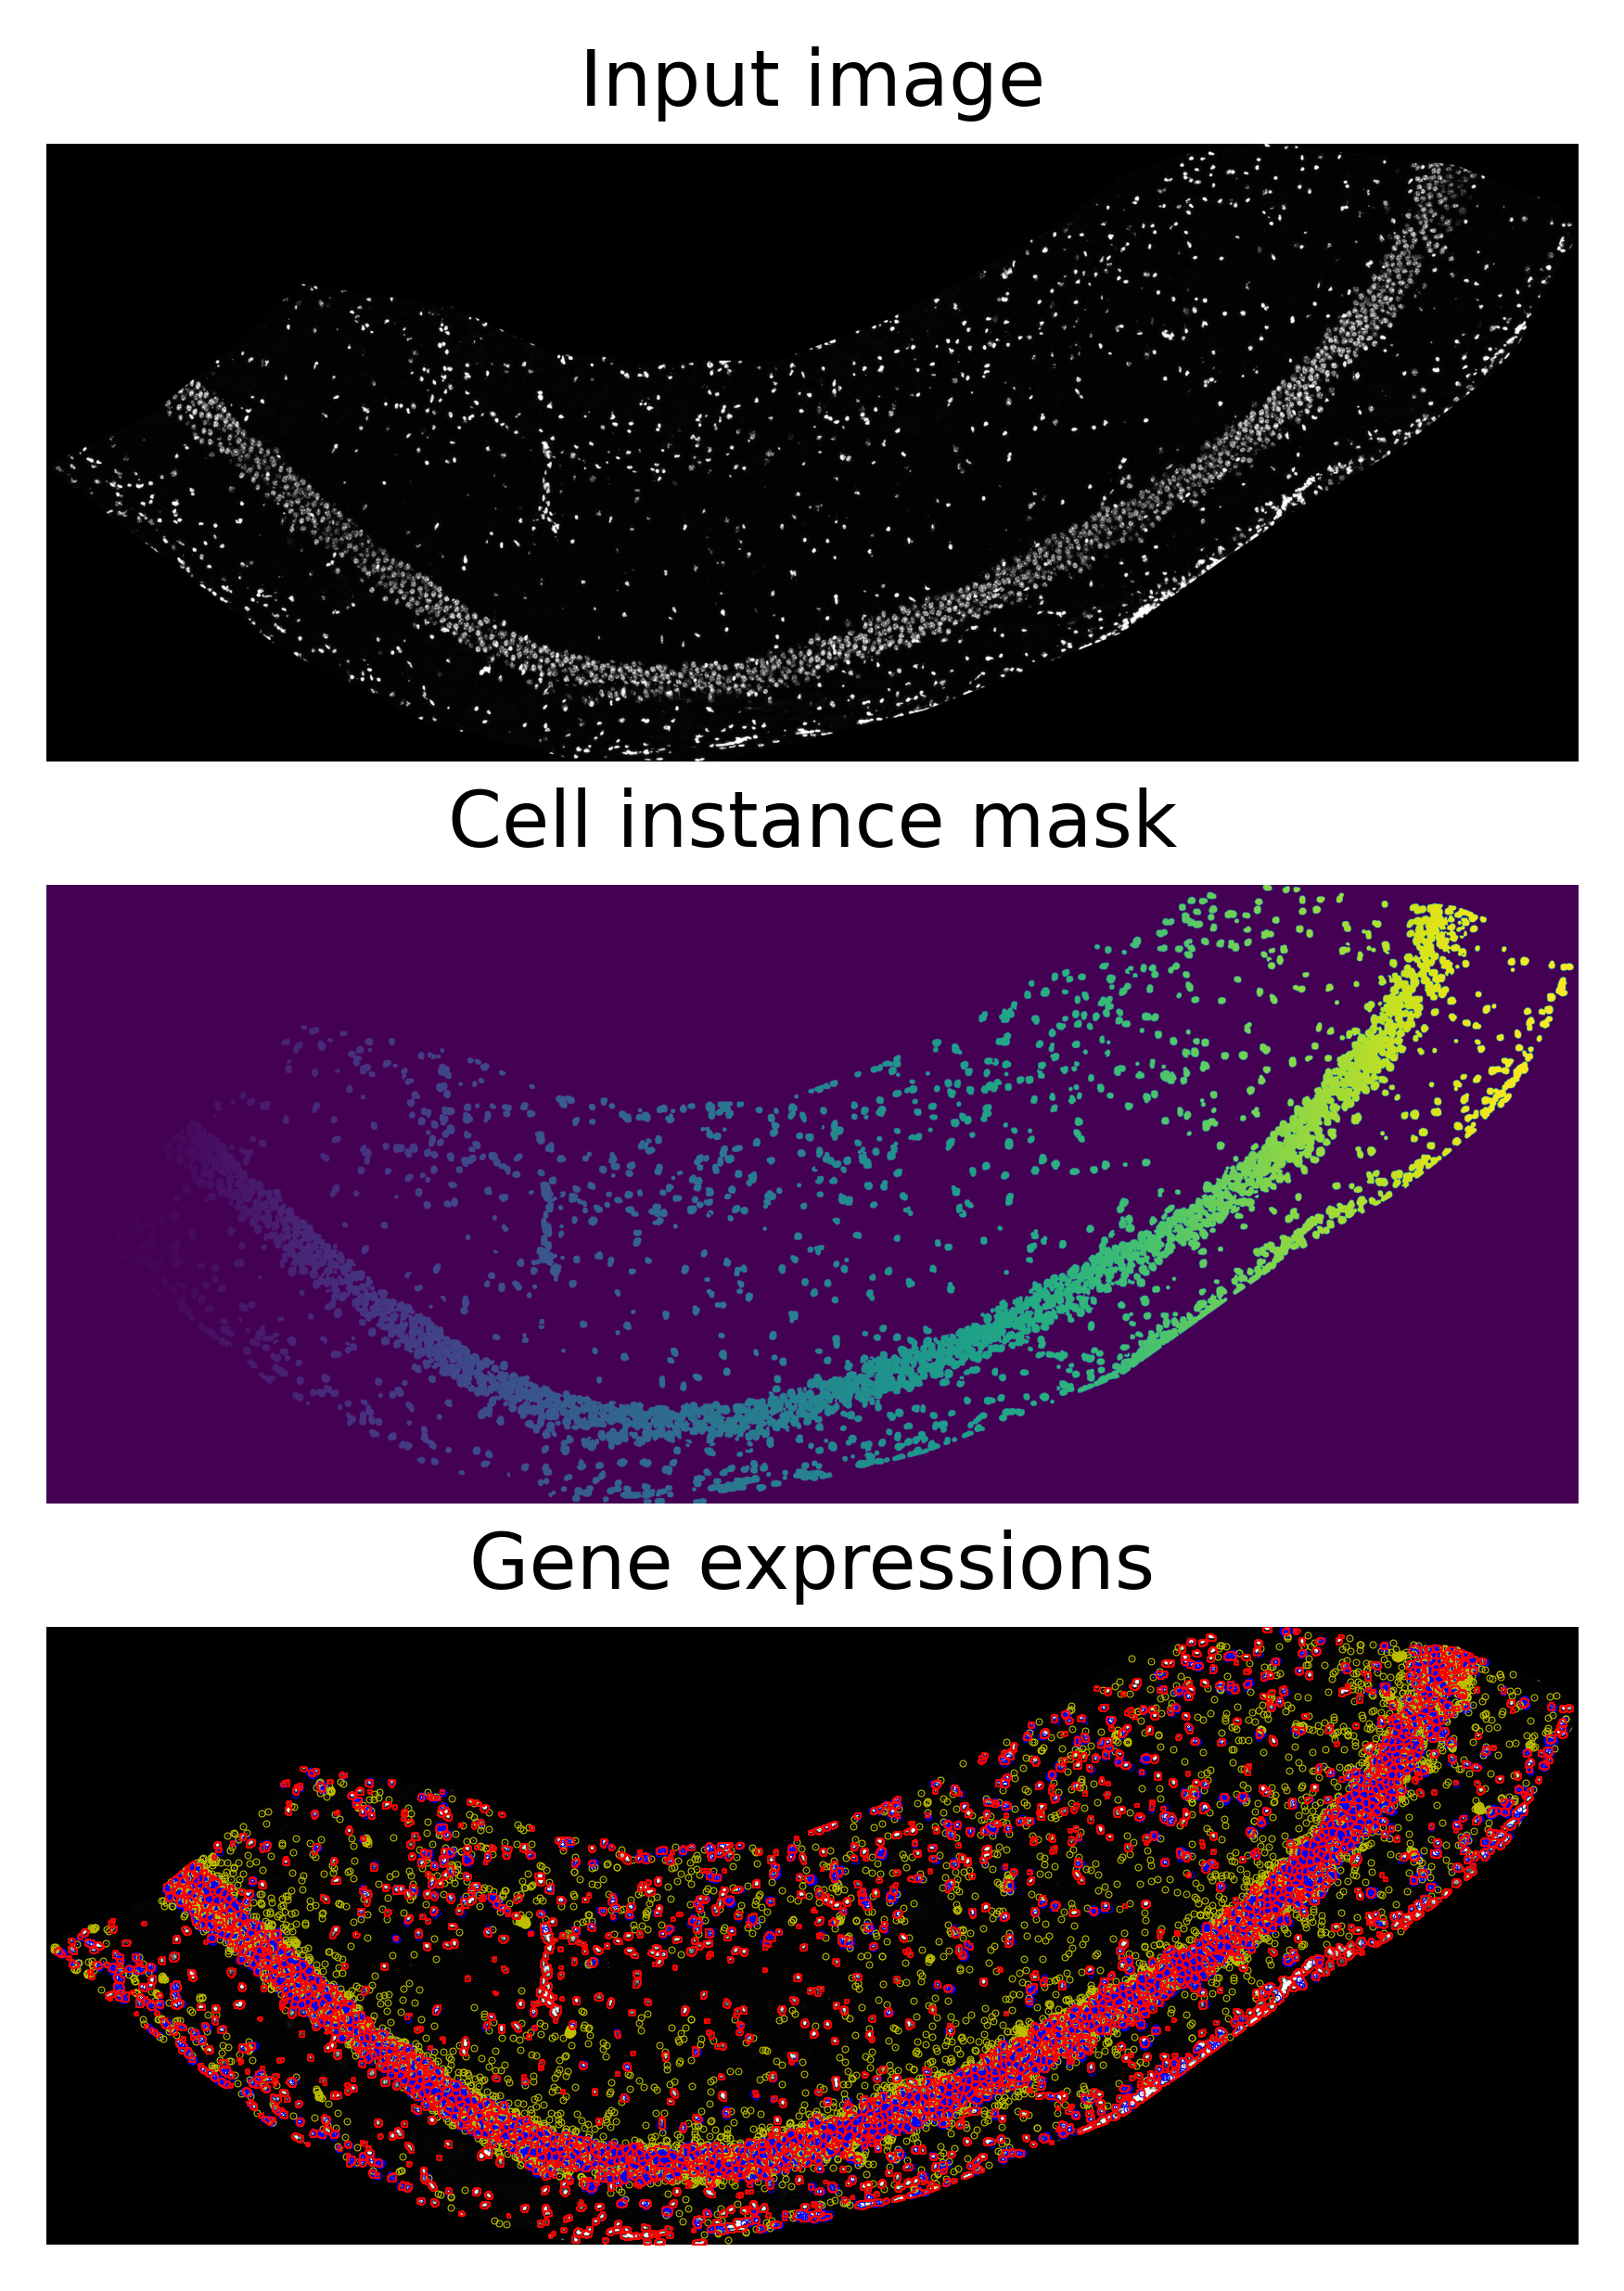

In [3]:
fig = plt.figure(figsize=(8,6), dpi=500)

lbout = label.copy()
imgout= image.copy()
spotout = spot[:,1:].astype(np.float64).astype(np.int32)
 
ax = fig.add_subplot(3,1,1)
ax.imshow(imgout)
ax.set_title('Input image')
ax.axis('off')
    
ax = fig.add_subplot(3,1,2)
ax.imshow(lbout)
ax.set_title('Cell instance mask')
ax.axis('off')

ax = fig.add_subplot(3,1,3)
outlines = utils.masks_to_outlines(lbout)
outX, outY = np.nonzero(outlines)

xs = spotout[:,0]
ys = spotout[:,1]

cell_in_mask = lbout[ys,xs] != 0
cell_out_mask = lbout[ys,xs] == 0
cell_in_spots = spotout[cell_in_mask]
cell_out_spots = spotout[cell_out_mask]

if len(cell_in_spots) != 0:
    ax.scatter(cell_in_spots[:,0],cell_in_spots[:,1], marker='.', c='b', s=0.1)
    
if len(cell_out_spots) != 0:
    ax.scatter(cell_out_spots[:,0], cell_out_spots[:,1], marker='.',c='y', s=0.1)

ax.scatter(outY, outX, marker = ',' , c='r', lw=0, s=0.1)
ax.imshow(imgout)
ax.set_title('Gene expressions')
ax.axis('off')

# 2. Preprocess Datasets 

## 2.1  Parameter configuration

In [4]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#Radius hyperparameter for generating gene heatmap   
sigma = 7
#The window size to execute SlidingWindow inference
roi_size = [256,256]
#The batch size to run window slices
sw_batch_size = 10
image_dir = "{}/image/DAPI_3-4_right.jpg".format(root_dir)
save_dir = "./datasets/cropped_data"

## 2.2 Preprocessing

In [5]:
#Crop image, cell instance mask and spot with Gaussion map generation
#Save cropped data into a path
C_images, C_labels, C_spots, C_gaussian, C_gaussian_all = preprocess.preprocessing(image, label, spot, 
                                                                                   sigma, roi_size, sw_batch_size, 
                                                                                   save_dir, image_dir, return_type=0, device=device)

save_dir: ./datasets/cropped_data\DAPI_3-4_right
saved_image_path: ./datasets/cropped_data\DAPI_3-4_right\images
saved_label_path: ./datasets/cropped_data\DAPI_3-4_right\labels
saved_spot_path: ./datasets/cropped_data\DAPI_3-4_right\spots
saved_gaumap_path: ./datasets/cropped_data\DAPI_3-4_right\GauMaps
The number of cropped image is 416


## 2.3 Visualize preprocessing data

In [6]:
index = [27, 59, 122, 173, 196, 399]
fig, ax = plt.subplots(len(index), 4, constrained_layout=True, figsize=(45,70), dpi=200)


label_batch = C_labels[index].squeeze().cpu().numpy().copy()
img_batch = C_images[index].permute((0,2,3,1)).cpu().numpy().copy()
spot_batch = np.array([spot.cpu().numpy().astype(np.float64).astype(np.int32) for spot in C_spots], dtype=object)[index].copy()
gaussian_btach = C_gaussian[index].squeeze().cpu().numpy().copy()

ax[0, 0].set_title('Cropped \n image',  fontdict={'fontsize': 100, 'fontweight': 'medium'})
ax[0, 1].set_title('Cropped \n label',  fontdict={'fontsize': 100, 'fontweight': 'medium'})
ax[0, 2].set_title('Cropped \n GeneExps',  fontdict={'fontsize': 100, 'fontweight': 'medium'})
ax[0, 3].set_title('Gaussian \n map',  fontdict={'fontsize': 100, 'fontweight': 'medium'})

for i, (lb, img, spot, gm) in enumerate(zip(label_batch, img_batch, spot_batch, gaussian_btach)):
    ax[i, 0].imshow(img)
    ax[i, 0].axis('off')
    
    ax[i, 1].imshow(lb)
    ax[i, 1].axis('off')
    
    outlines = utils.masks_to_outlines(lb)
    outX, outY = np.nonzero(outlines)

    xs = spot[:,0]
    ys = spot[:,1]

    cell_in_mask = lb[ys,xs] != 0
    cell_out_mask = lb[ys,xs] == 0
    cell_in_spots = spot[cell_in_mask]
    cell_out_spots = spot[cell_out_mask]
    
    if len(cell_in_spots) != 0:
        ax[i, 2].scatter(cell_in_spots[:,0],cell_in_spots[:,1], marker='o', c='b', s=300)
    
    if len(cell_out_spots) != 0:
        ax[i, 2].scatter(cell_out_spots[:,0], cell_out_spots[:,1], marker='o',c='y', s=300)
    
    ax[i, 2].scatter(outY, outX, marker = ',' , c='r', lw=0, s=50)
    ax[i, 2].imshow(img)
    ax[i, 2].axis('off')
    
    gm = cv2.applyColorMap((gm).astype(np.uint8), cv2.COLORMAP_JET)[...,[2,1,0]]
    ax[i, 3].imshow(gm)
    ax[i, 3].axis('off')

# 3. Training

#### Here, we just use small datasets to show training process. If you want better training results, you need to preprocess at least 3000 images 

## 3.1 Training parameters

In [7]:
pretrained_model = None
diam_mean = 34.0
residual_on = 1
style_on = 1
concatenation = 0
learning_rate = 0.01
weight_decay = 1e-5
save_every = 1
n_epochs = 50
batch_size =4
min_train_masks = 2

## 3.2 Initialize training model

In [8]:
model = models.GsegModel(gpu=True, device=device,
                                pretrained_model=pretrained_model, 
                                diam_mean= diam_mean,
                                residual_on=residual_on,
                                style_on=style_on,
                                concatenation=concatenation,
                                nchan=4)

## 3.3 Split data into training data and test data

In [9]:
C_images_np = C_images.permute((0,2,3,1)).cpu().numpy()
C_labels_np =  C_labels.squeeze(1).cpu().numpy()
C_spots_np = [spot.cpu().numpy() for spot in C_spots]
C_gaussian_np = C_gaussian.squeeze(1).cpu().numpy()
C_gaussian_all_np = C_gaussian_all.squeeze(1).cpu().numpy()
label_names = natsorted(glob.glob(os.path.join(os.path.join("./datasets/cropped_data/DAPI_3-4_right", 'labels'), '*.png')))

images, labels, spots, gaumaps, gaumaps_all  = C_images_np[:300], C_labels_np[:300], C_spots_np[:300], C_gaussian_np[:300], C_gaussian_all_np[:300]
test_images, test_labels, test_spots, test_gaumaps, test_gaumaps_all  = C_images_np[300:], C_labels_np[300:], C_spots_np[300:], C_gaussian_np[300:], C_gaussian_all_np[300:] 

label_names, test_label_names = label_names[:300], label_names[300:]

#load images and gaussian maps for training
images_gaumaps = []
for n, (image, gaumap, gaumap_all) in enumerate(zip(images, gaumaps, gaumaps_all)):
    images_gaumaps.append(np.concatenate((image, gaumap[:,:,np.newaxis], gaumap_all[:,:,np.newaxis]), axis=2)) 

images = np.array(images_gaumaps)

#load images and gaussian maps for test
images_gaumaps_test = []
for n, (test_image, test_gaumap, test_gaumap_all) in enumerate(zip(test_images, test_gaumaps, test_gaumaps_all)):
    images_gaumaps_test.append(np.concatenate((test_image, test_gaumap[:,:,np.newaxis], test_gaumap_all[:,:,np.newaxis]), axis=2)) 

test_images = np.array(images_gaumaps_test)

## 3.4 Run training

In [ ]:
model_path = model.train(images, labels, train_files=label_names,
                            test_data=test_images, test_labels=test_labels, test_files=test_label_names,
                            learning_rate=learning_rate, 
                            weight_decay=weight_decay,
                            channels=None,
                            save_path=os.path.realpath("./datasets/original_data"), save_every=save_every,
                            save_each=5,
                            n_epochs=n_epochs,
                            batch_size=batch_size, 
                            min_train_masks=min_train_masks)

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
  8%|██████▍                                                                         | 24/300 [00:00<00:01, 146.64it/s]empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
 13%|██████████▌                                                                      | 39/300 [00:00<00:02, 94.93it/s]empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
 19%|██████████████▉                                                   

# 4. Test

## 4.1 Test parameters

In [7]:
gpu = True
device = torch.device('cuda:0')
pretrained_model = './cellpose_residual_on_style_on_concatenation_off_img_label_2022_05_18_22_27_39.655941_epoch_499'
model_type = None
szmean = 34.0
residual_on = 1
style_on = 1
concatenation = 0

## 4.2 Initialize test model

In [8]:
model = models.GsegModel(gpu=gpu, device=device, 
                            pretrained_model=pretrained_model,
                            diam_mean=szmean,
                            residual_on=residual_on,
                            style_on=style_on,
                            concatenation=concatenation,
                            net_avg=False,
                            nchan=4)

## 4.3 Stitch cell instance masks

In [10]:
image_tensor = torch.from_numpy(image).permute((2,0,1)).unsqueeze(0).to(device)
spot_tensor = torch.from_numpy(spot[:,1:].astype(np.float64).astype(np.int32)).to(device)
    
cellprob, dP = slidingwindows_gradient.sliding_window_inference(image_tensor, roi_size, sw_batch_size, model, spot_tensor, sigma, "DAPI_3-4_right", "./datasets/cropped_data/", device)

image: (3034, 7522, 3)
spot: (16255, 3)
saved_gaumap_path: ./datasets/cropped_data/GauMap\DAPI_3-4_right
Existed gaumap 0_gaumap.jpg
Existed gaumap 1_gaumap.jpg
Existed gaumap 2_gaumap.jpg
Existed gaumap 3_gaumap.jpg
Existed gaumap 4_gaumap.jpg
Existed gaumap 5_gaumap.jpg
Existed gaumap 6_gaumap.jpg
Existed gaumap 7_gaumap.jpg
Existed gaumap 8_gaumap.jpg
Existed gaumap 9_gaumap.jpg
Existed gaumap 10_gaumap.jpg
Existed gaumap 11_gaumap.jpg
Existed gaumap 12_gaumap.jpg
Existed gaumap 13_gaumap.jpg
Existed gaumap 14_gaumap.jpg
Existed gaumap 15_gaumap.jpg
Existed gaumap 16_gaumap.jpg
Existed gaumap 17_gaumap.jpg
Existed gaumap 18_gaumap.jpg
Existed gaumap 19_gaumap.jpg
Existed gaumap 20_gaumap.jpg
Existed gaumap 21_gaumap.jpg
Existed gaumap 22_gaumap.jpg
Existed gaumap 23_gaumap.jpg
Existed gaumap 24_gaumap.jpg
Existed gaumap 25_gaumap.jpg
Existed gaumap 26_gaumap.jpg
Existed gaumap 27_gaumap.jpg
Existed gaumap 28_gaumap.jpg
Existed gaumap 29_gaumap.jpg
Existed gaumap 30_gaumap.jpg
Existe

cellprob: torch.Size([1, 1, 3034, 7522])
dP: torch.Size([1, 2, 3034, 7522])


In [14]:
niter = 1 / 1.0625 * 200
outputs = dynamics.compute_masks(dP.squeeze().cpu().numpy(), cellprob.squeeze().cpu().numpy(), niter=niter, cellprob_threshold=0,
                                                 flow_threshold=0.4, interp=True, resize=None,
                                                 use_gpu=True, device='cuda:0')

wholemask = outputs[0]

kernel = np.ones((5,5), np.uint8)
wholemask = cv2.morphologyEx(wholemask, cv2.MORPH_OPEN, kernel)

(-0.5, 7521.5, 3033.5, -0.5)

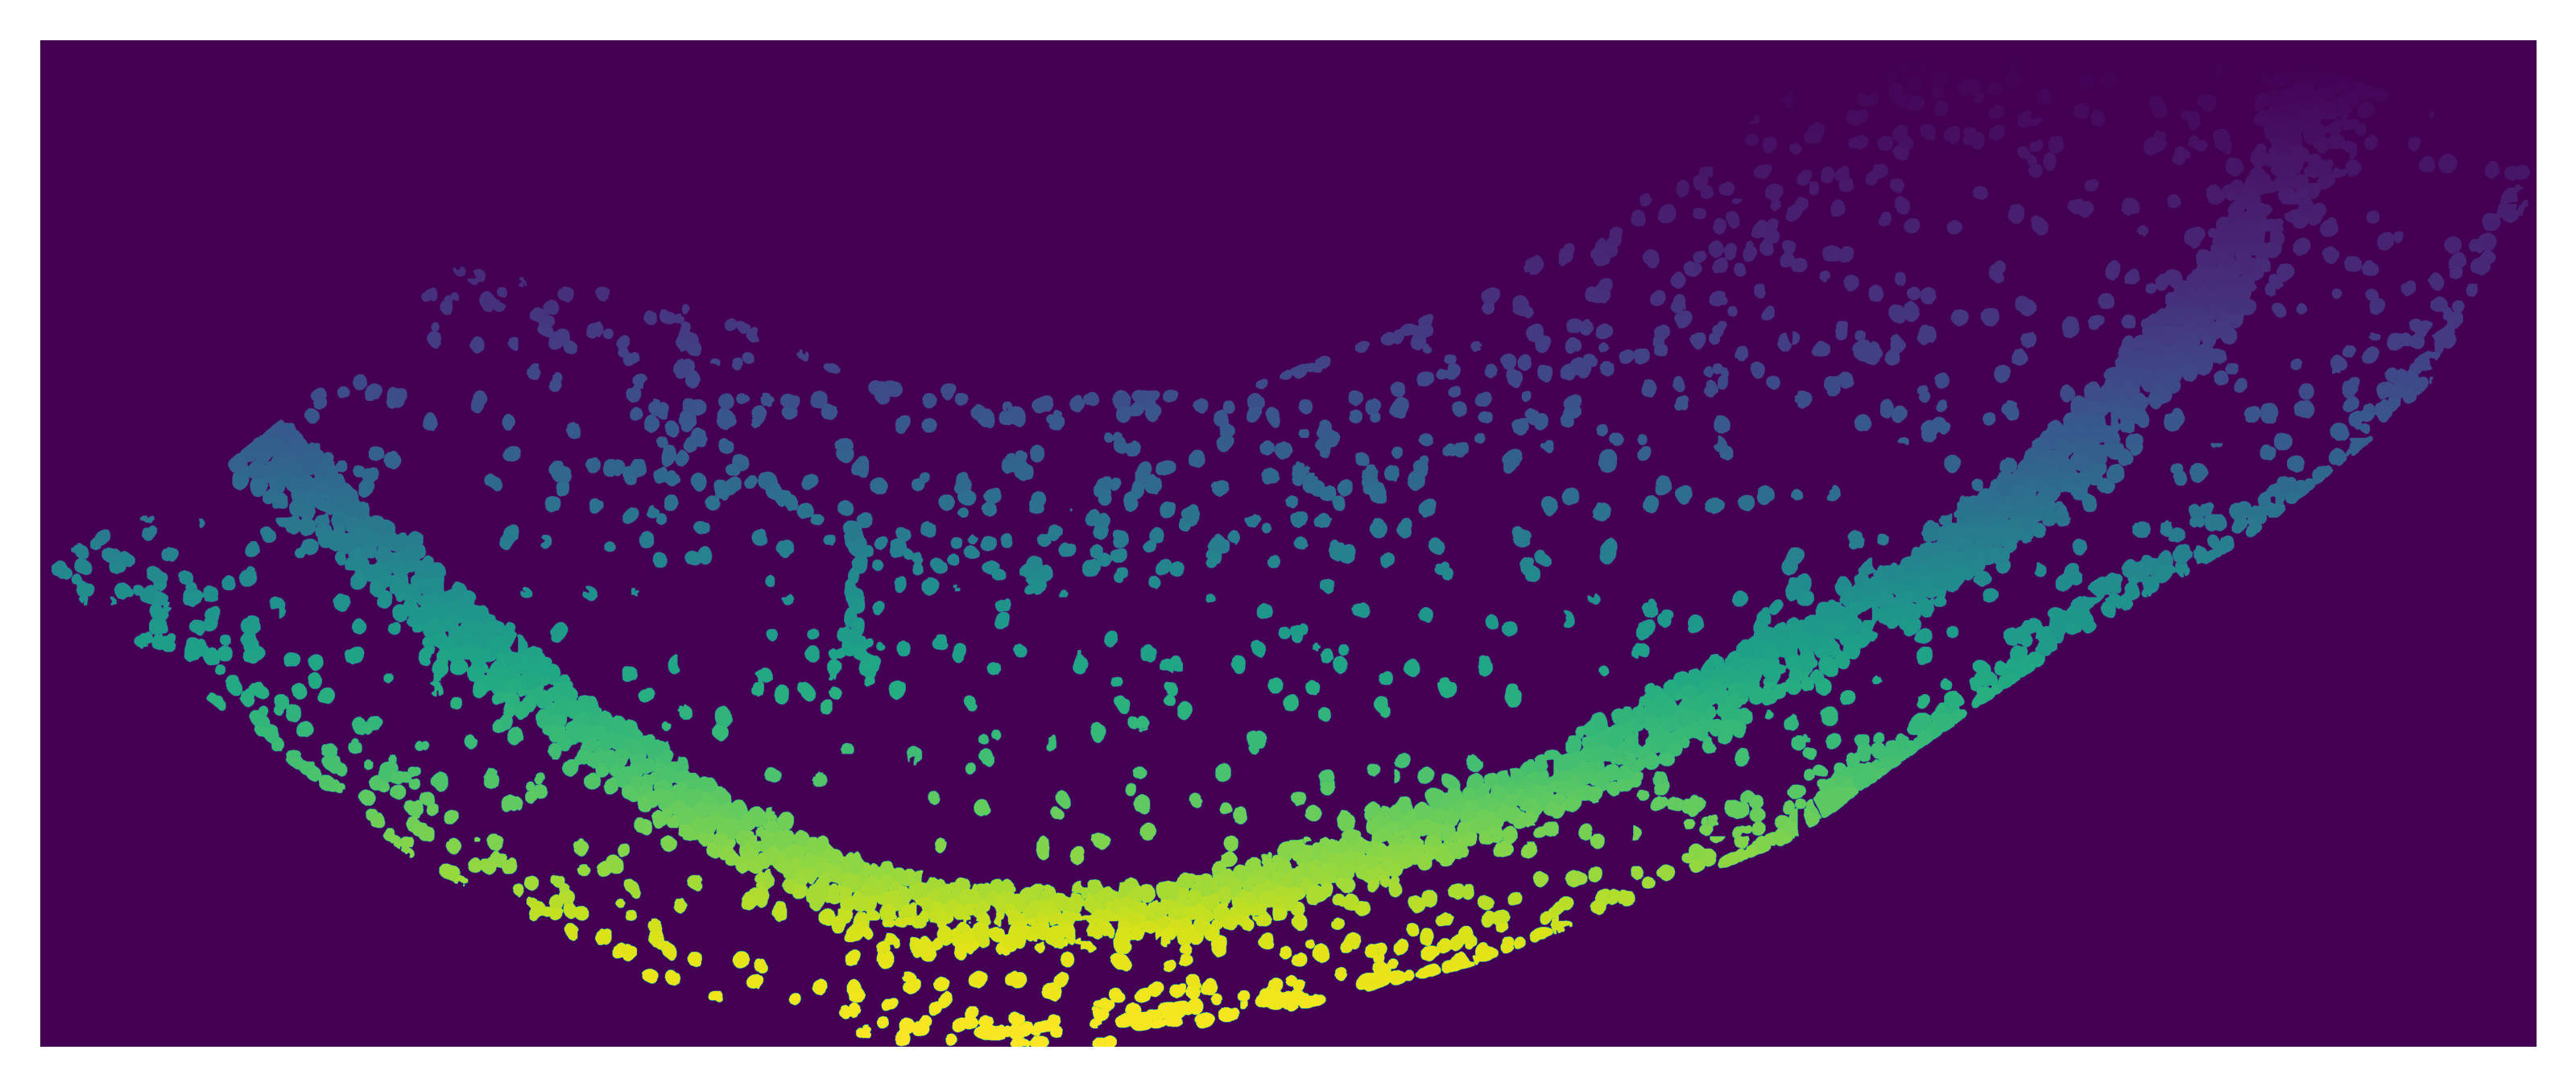

In [16]:
plt.figure(figsize=(8,6), dpi=500)
plt.imshow(wholemask)
plt.axis("off")